# Lunar Lander : Deep Q-Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
env = gym.make('LunarLander-v2')

## The Q-Network / Replay Buffer / DQN Agent

In [4]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
class ReplayBuffer():
    def __init__(self, buffer_size, batch_size):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.memory = []
    
    def __len__(self):
        return len(self.memory)
    
    def add(self, state, action, reward, next_state, done):
        exp = (state, action, reward, next_state, done)
        if (len(self.memory) == self.buffer_size):
            self.memory.pop(0)
        self.memory.append(exp)
    
    def sample(self):
        exp = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for xp in exp:
            states.append(xp[0])
            actions.append(xp[1])
            rewards.append(xp[2])
            next_states.append(xp[3])
            dones.append(xp[4])
        return (torch.FloatTensor(states).to(device), torch.LongTensor(actions).unsqueeze(1).to(device), torch.FloatTensor(rewards).to(device), torch.FloatTensor(next_states).to(device), torch.FloatTensor(dones).to(device))

In [6]:
class DQNAgent():
    def __init__(self, state_dim, action_dim, buffer_size, batch_size, discount, learning_rate):
        self.action_dim = action_dim
        self.discount = discount
        self.batch_size = batch_size
        self.q_network = QNetwork(state_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.replay_buffer = ReplayBuffer(buffer_size, self.batch_size)
    
    def step(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
        if (len(self.replay_buffer) >= self.batch_size):
            exp = self.replay_buffer.sample()
            self.learn(exp)
    
    def learn(self, exp):
        states, actions, rewards, next_states, dones = exp
        outputs = self.q_network(next_states).detach()
        action_values = torch.max(outputs, dim=1).values
        q_target = (rewards + (self.discount * action_values * (1.0 - dones))).unsqueeze(1)
        q_value = torch.gather(self.q_network(states), 1, actions)
        criterion = nn.MSELoss()
        loss = criterion(q_target, q_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def selectAction(self, state, epsilon):
        if (np.random.random() < epsilon):
            return np.random.randint(self.action_dim)
        else:
            state = torch.from_numpy(state).to(device)
            self.q_network.eval()
            with torch.no_grad():
                output = self.q_network(state)
            self.q_network.train()
            return np.argmax(output.cpu()).item()

## Training the DQN Agent

In [14]:
episodes = 500
max_steps = 1000

epsilon = 1.0
decay = 0.995
epsilon_min = 0.01

discount = 0.99
learning_rate = 0.0001

buffer_size = 100000
batch_size = 64

In [15]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

In [16]:
dqn_agent = DQNAgent(state_dim, action_dim, buffer_size, batch_size, discount, learning_rate)

In [17]:
scores = []
for ep in range(1, episodes + 1):
    print("\r Episode {}/{}".format(ep, episodes), end='')
    done = False
    state = env.reset()
    score = 0
    step = 0
    while (done == False and step < max_steps):
        action = dqn_agent.selectAction(state, epsilon)
        next_state, reward, done, info = env.step(action)
        dqn_agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        step += 1
    if epsilon > epsilon_min:
        epsilon *= decay
    scores.append(score)

 Episode 500/500

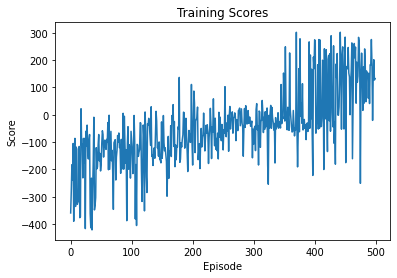

In [18]:
plt.plot(scores)
plt.title("Training Scores")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.show()

## Playing with the trained DQN Agent

In [20]:
for ep in range(5):
    score = 0
    state = env.reset()
    for step in range(1000):
        env.render()
        action = dqn_agent.selectAction(state, 0.0)
        next_state, reward, done, info = env.step(action)
        state = next_state
        score += reward
        if (done):
            break
    print("Episode {} - Score : {}".format(ep, score))
env.close()

Episode 0 - Score : 179.51520921255667
Episode 1 - Score : 76.68415068313831
Episode 2 - Score : 88.99209044799348
Episode 3 - Score : 142.91063693108342
Episode 4 - Score : 201.60457814028968
